In [1]:
import sys
import os

import torch
import random
import warnings
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import torchvision
import torchvision.transforms.functional as TF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import Convolve
from scipy.ndimage import gaussian_filter1d
from cca_zoo.linear import rCCA
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

# Import MI files
from utils import *
from models import *
from estimators import *
from trainers import *

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['figure.dpi'] = 100

# Set global font sizes for better readability
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.titlesize': 18})
plt.rcParams.update({'axes.labelsize': 16})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'legend.fontsize': 15})

# Directories
main_dir = os.getcwd()
model_cache_dir = os.path.join(main_dir, '..', 'model_cache')

# Set default type now
default_dtype = torch.float32
torch.set_default_dtype(default_dtype)

# To-do list:
Main:
- [X] Improve data loading
- [] Clean up CNN functions, move to their correct places


Low priority:
- [] Remove chunked inference, it has issues. Swap to CPU based inference, only run post-hoc
- [] Try ISI encoding instead (as in https://pmc.ncbi.nlm.nih.gov/articles/PMC9870156/)

- [/] Parallel training with shared memory, fixed to have the right number of processes


In [2]:
# Check if CUDA or MPS is running
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = "CPU"

print(f'Device: {device}')

Device: cuda


In [72]:
def get_spike_indices(base_name, neuron_label_filter=None):
    # File names
    data_file = base_name + "_data.npz"
    labels_file = base_name + "_labels.npz"
    # Load the spike data
    if not os.path.exists(data_file):
        raise FileNotFoundError(f"Data file '{data_file}' not found.")
    data = np.load(data_file)
    units = data.files  # List of unit labels
    # Load the labels file if it exists
    labels = {}
    if os.path.exists(labels_file):
        labels_data = np.load(labels_file)
        labels = {unit: labels_data[unit].item() for unit in labels_data.files}
    # Separate neurons and muscles, applying filtering if needed
    neuron_labels = []
    muscle_labels = []
    for unit in units:
        if unit.isnumeric():  # Numeric labels are neurons
            if labels:
                label = labels.get(unit, None)
                if neuron_label_filter is None or label == neuron_label_filter:
                    neuron_labels.append(unit)
            else:
                neuron_labels.append(unit)  # No filtering if no labels file
        else:  # Alphabetic labels are muscles
            muscle_labels.append(unit)
    return data, neuron_labels, muscle_labels

Neurons (X): torch.Size([32, 3731116])
Muscles (Y): torch.Size([10, 3731116])
Neuron Labels: ['87', '29', '1', '78', '12', '20', '2', '6', '41', '11', '13', '65', '89', '15', '75', '42', '33', '28', '14', '39', '21', '7', '96', '68', '8', '88', '93', '26', '10', '0', '30', '3']
Muscle Labels: ['rsa', 'rdvm', 'lba', 'ldvm', 'rdlm', 'lsa', 'rax', 'lax', 'rba', 'ldlm']


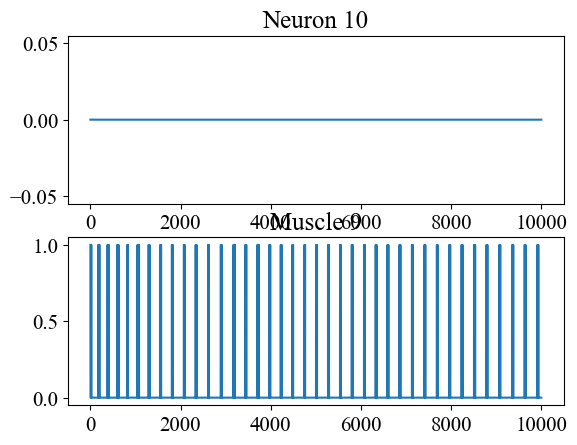

In [18]:
# Read the data and have some binning
data_dir = os.path.join(os.getcwd(), '..', 'data_for_python')
tic = time.time()
X, Y, x_labels, y_labels = read_spike_data(os.path.join(data_dir, '2025-03-21'), 0.0005)
# Convert to torch tensors
X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)

print(f"Neurons (X): {X.shape}")
print(f"Muscles (Y): {Y.shape}") 
print("Neuron Labels:", x_labels)
print("Muscle Labels:", y_labels)

# Plot sample of activity
pl = 10000
useneuron, usemuscle = np.random.choice(X.shape[0]), np.random.choice(Y.shape[0])
idx = torch.nonzero(Y[usemuscle,:] > 0)[0][0]
fig, ax = plt.subplots(2, 1)
ax[0].plot(X[useneuron,idx:idx+pl])
ax[1].plot(Y[usemuscle,idx:idx+pl])
ax[0].set_title(f'Neuron {useneuron}')
ax[1].set_title(f'Muscle {usemuscle}')
fig.show()

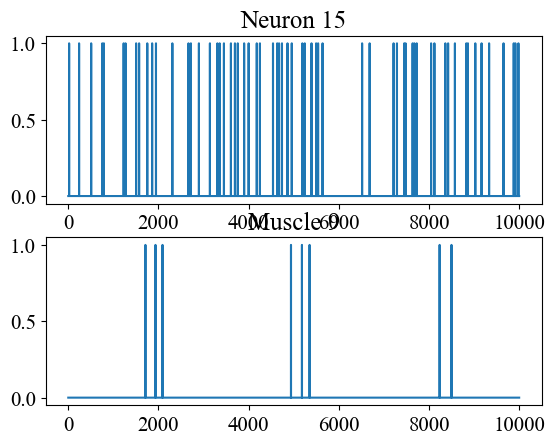

In [48]:
pl = 10000
useneuron, usemuscle = np.random.choice(X.shape[0]), np.random.choice(Y.shape[0])
# useneuron = 29
idx = torch.nonzero(Y[usemuscle,:] > 0)[0][0]
fig, ax = plt.subplots(2, 1)
idx = idx + 4000
ax[0].plot(X[useneuron,idx:idx+pl])
ax[1].plot(Y[usemuscle,idx:idx+pl])
ax[0].set_title(f'Neuron {useneuron}')
ax[1].set_title(f'Muscle {usemuscle}')
fig.show()

In [23]:
params = {
    # Optimizer parameters (for training)
    'epochs': 200,
    'batch_size': 128,
    'learning_rate': 5e-3,
    'n_trials': 3,
    'patience': 20,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    # Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
    'Nx': X.shape[0],
    'Ny': Y.shape[0],
    'layers': 4,
    'fc_layers': 2, # fully connected layers, only for if using CNNs from data_form: 'image' 
    'hidden_dim': 512,
    'activation': nn.Softplus, #'leaky_relu',
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'data_form': 'image',
    'mode': 'sep', # Almost always we'll use separable
    'chunked_inference': False, 
    'chunk_size': 1000,
}

In [ ]:
def create_cnn_data_split(dataset, batch_size, train_fraction=0.95, eval_fraction=None, eval_from_train=True, device=None):
    """
    Creates train loader and test/eval data views
    Args:
        dataset (FullAndBatchedDataset): The dataset containing all data
        train_fraction (float): Fraction of batches to use for training
        device (torch.device): Device to move test/eval data to
        
    Returns:
        tuple: (train_loader, test_data, eval_data)
    """
    # Generate train/test splits
    train_size = int(train_fraction * len(dataset.batch_indices))
    # Create train/test/eval indices, separate eval set with different random indices
    traintest_indices = torch.randperm(len(dataset.batch_indices))
    train_indices = traintest_indices[:train_size]
    test_indices = traintest_indices[train_size:]
    # Generate eval split, either from train subset or independently
    eval_fraction = (1 - train_fraction) if eval_fraction is None else eval_fraction
    eval_size = int(eval_fraction * len(dataset.batch_indices))
    if eval_from_train:
        eval_indices = traintest_indices[:eval_size]
    else:
        eval_indices = torch.randperm(len(dataset.batch_indices))[:eval_size]
    # Create training data loader, send test and eval to device
    train_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=SubsetRandomSampler(train_indices),
        num_workers=0  # Adjust based on your system
    )
    # Get test and eval data as views. Batches are sorted to be presented in real data order
    test_loader = DataLoader(dataset, batch_size=len(test_indices), sampler=SubsetRandomSampler(test_indices))
    eval_loader = DataLoader(dataset, batch_size=len(eval_indices), sampler=SubsetRandomSampler(eval_indices))
    return train_loader, test_loader, eval_loader

In [25]:

def train_cnn_model(model_func, full_dataset, params, device=device):
    """
    Generalized training function for DSIB and DVSIB models with early stopping.
    Version that does not run evaluation! Skimps on that to save time, returns only mi values from test
    Args:
        model: The model to train (DSIB or DVSIB).
        data: Tuple of (train, test, eval) dataloaders. 
            Assumes uses BatchSubsetDataset with custom sampler
            Assumes loaders return X, Y of shapes (M_x, N) and (M_y, N)
    Returns:
        An array test_estimates containing mutual information estimates of TEST SET ONLY
    """
    # Initialize model
    model_name = model_func.__name__
    model = model_func(params)
    model.to(device)  # Ensure model is on GPU
    # Pull out data loaders
    train_data, test_loader, eval_loader = full_dataset
    # Pull out test data. Loader just constructs a giant single batch
    test_X, test_Y = list(iter(test_loader))[0]
    test_X, test_Y = test_X.unsqueeze(1).to(device), test_Y.unsqueeze(1).to(device)
    eval_X, eval_Y = list(iter(eval_loader))[0]
    eval_X, eval_Y = eval_X.unsqueeze(1).to(device), eval_Y.unsqueeze(1).to(device)
    # Initialize variables
    epochs = params['epochs']
    opt = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], eps=params['eps'])
    estimates_mi_test = []
    estimates_mi_train = []
    best_estimator_ts = float('-inf')  # Initialize with negative infinity
    no_improvement_count = 0
    for epoch in range(epochs):
        start = time.time()
        for i, (x, y) in enumerate(iter(train_data)):
            # Add extra dim to represent number of channels (1 because "images" are one-hot encoded, no RGB)
            x, y = x.unsqueeze(1).to(device), y.unsqueeze(1).to(device)
            opt.zero_grad()
            # Compute loss based on model type
            if model_name == "DSIB":
                loss = model(x, y)  # DSIB returns a single loss
            elif model_name == "DVSIB":
                loss, _, _ = model(x, y)  # DVSIB returns three outputs
            else:
                raise ValueError("Invalid model_type. Choose 'DSIB' or 'DVSIB'.")
            loss.backward()
            opt.step()
        print(f'Train time = {time.time() - start}')
        # Test model at every epoch
        with torch.no_grad():
            if model_name == "DSIB":
                start = time.time()
                estimator_tr = -model(eval_X, eval_Y)
                print(f'Eval time = {time.time() - start}')
                start = time.time()
                estimator_ts = -model(test_X, test_Y)
                print(f'Test time = {time.time() - start}')
            elif model_name == "DVSIB": # Get lossGout, that is the mi value
                _, _, estimator_ts = model(test_X, test_Y)
            estimator_tr = estimator_tr.to('cpu').detach().numpy()
            estimator_ts = estimator_ts.to('cpu').detach().numpy()
            estimates_mi_train.append(estimator_tr)
            estimates_mi_test.append(estimator_ts)
        print(f"Epoch: {epoch+1}, {model_name}, train: {estimator_tr}, test: {estimator_ts}", flush=True)
        # Check for improvement, negative values, or nans
        if np.isnan(estimator_tr) and np.isnan(estimator_ts):
            print('Early stop due to nan outputs')
            break
        if estimator_ts < 0:
            no_improvement_count += 1
        elif estimator_ts > best_estimator_ts + params['min_delta']:
            # We have an improvement
            best_estimator_ts = estimator_ts
            no_improvement_count = 0
        else:
            # No significant improvement
            no_improvement_count += 1
        # Check if we should stop early
        if no_improvement_count >= params['patience']:
            print(f"Early stopping triggered after {epoch+1} epochs. Best estimator_ts: {best_estimator_ts}")
            break
    return np.array(estimates_mi_train), np.array(estimates_mi_test), model

def train_cnn_model_no_eval(model_func, full_dataset, params, model_save_dir, device=device):
    """
    Generalized training function for DSIB and DVSIB models with early stopping.
    Version that does not run evaluation! Skimps on that to save time, returns only mi values from test
    Args:
        model: The model to train (DSIB or DVSIB).
        data: Tuple of (train, test, eval) dataloaders. 
            Assumes uses BatchSubsetDataset with custom sampler
            Assumes loaders return X, Y of shapes (M_x, N) and (M_y, N)
    Returns:
        An array test_estimates containing mutual information estimates of TEST SET ONLY
    """
    # Initialize model
    model_name = model_func.__name__
    model = model_func(params)
    model.to(device)  # Ensure model is on GPU
    # Make save directory if it doesn't exist, generate unique model id
    os.makedirs(model_save_dir, exist_ok=True)
    train_id = model_name + '_' + f'dz-{params["embed_dim"]}_' + f'bs-{params["batch_size"]}_' + str(uuid.uuid4())
    # Pull out data loaders
    train_data, test_loader, _ = full_dataset
    # Pull out test data. Loader just constructs a giant single batch
    test_X, test_Y = list(iter(test_loader))[0]
    test_X, test_Y = test_X.unsqueeze(1).to(device), test_Y.unsqueeze(1).to(device)
    # Initialize variables
    epochs = params['epochs']
    opt = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], eps=params['eps'])
    estimates_mi_test = []
    best_estimator_ts = float('-inf')  # Initialize with negative infinity
    no_improvement_count = 0
    for epoch in range(epochs):
        start = time.time()
        for i, (x, y) in enumerate(iter(train_data)):
            # Add extra dim to represent number of channels (1 because "images" are one-hot encoded, no RGB)
            x, y = x.unsqueeze(1).to(device), y.unsqueeze(1).to(device)
            opt.zero_grad()
            # Compute loss based on model type
            if model_name == "DSIB":
                loss = model(x, y)  # DSIB returns a single loss
            elif model_name == "DVSIB":
                loss, _, _ = model(x, y)  # DVSIB returns three outputs
            else:
                raise ValueError("Invalid model_type. Choose 'DSIB' or 'DVSIB'.")
            loss.backward()
            opt.step()
        print(f'Train time = {time.time() - start}')
        # Test model at every epoch
        with torch.no_grad():
            if model_name == "DSIB":
                start = time.time()
                estimator_ts = -model(test_X, test_Y)
                print(f'Test time = {time.time() - start}')
            elif model_name == "DVSIB": # Get lossGout, that is the mi value
                _, _, estimator_ts = model(test_X, test_Y)
            estimator_ts = estimator_ts.to('cpu').detach().numpy()
            estimates_mi_test.append(estimator_ts)
        print(f"Epoch: {epoch+1}, {model_name}, test: {estimator_ts}", flush=True)
        # Save snapshot of model
        torch.save(
            model, 
            os.path.join(model_save_dir, f'epoch{epoch}_' + train_id + '.pt')
        )
        # Check for improvement, negative values, or nans
        if np.isnan(estimator_ts):
            print('Early stop due to nan outputs')
            break
        if estimator_ts < 0:
            no_improvement_count += 1
        elif estimator_ts > best_estimator_ts + params['min_delta']:
            # We have an improvement
            best_estimator_ts = estimator_ts
            no_improvement_count = 0
        else:
            # No significant improvement
            no_improvement_count += 1
        # Check if we should stop early
        if no_improvement_count >= params['patience']:
            print(f"Early stopping triggered after {epoch+1} epochs. Best estimator_ts: {best_estimator_ts}")
            break
    return np.array(estimates_mi_test), train_id


In [26]:
torch.cuda.empty_cache()
this_params = {**params, 'embed_dim': 10, 'batch_size': 256}
dataset = BatchedDataset(X, Y, this_params['batch_size'])
full_dataset = create_cnn_data_split(dataset, batch_size=60, train_fraction=0.9, eval_fraction=0.9, device=device)
mis, mis_test, mod = train_cnn_model(DSIB, full_dataset, this_params)
# misv, misv_test = train_model(DVSIB, full_dataset, this_params)

Train time = 2.6111900806427
Eval time = 0.5686767101287842
Test time = 0.006005525588989258
Epoch: 1, DSIB, train: -0.0008194353431463242, test: -0.000841523171402514
Train time = 1.6509099006652832
Eval time = 0.002001047134399414
Test time = 0.0020020008087158203
Epoch: 2, DSIB, train: 0.00011779415945056826, test: -1.5139986317080911e-05
Train time = 1.654503345489502
Eval time = 0.0020020008087158203
Test time = 0.003002643585205078
Epoch: 3, DSIB, train: 0.0024453578516840935, test: 0.001535119372420013
Train time = 1.653503179550171
Eval time = 0.0030024051666259766
Test time = 0.0020020008087158203
Epoch: 4, DSIB, train: 0.3231947422027588, test: 0.2935448884963989
Train time = 1.657505989074707
Eval time = 0.002001523971557617
Test time = 0.0020017623901367188
Epoch: 5, DSIB, train: 0.46199658513069153, test: 0.4353547692298889
Train time = 1.64849853515625
Eval time = 0.002001523971557617
Test time = 0.0020020008087158203
Epoch: 6, DSIB, train: 0.4976121485233307, test: 0.490

Text(0, 0.5, 'MI')

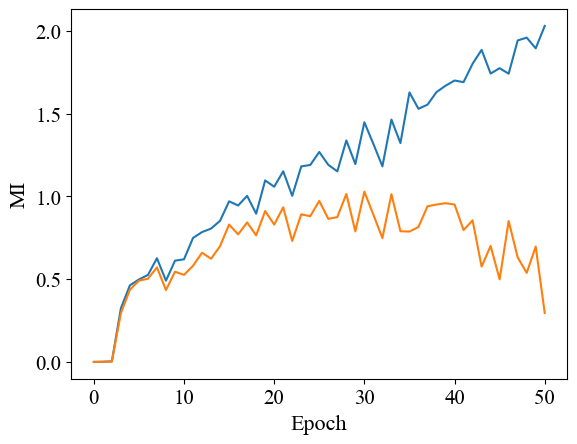

In [27]:
plt.plot(mis)
plt.plot(mis_test)
plt.xlabel('Epoch')
plt.ylabel('MI')

Things to know:

- What batch size, embed_dim work best?
- What effect does meta/actual batch size have?

144 runs took ~ 5 hours

Does batch size matter, all else being equal?

In [32]:
# Vary batch size, nothing else
mib = {}
mib_test = {}
batch_size_range = np.array([20, 40, 60, 80, 100], int)
dz = 10
windowsize = 128

for bs in batch_size_range:
    this_params = {**params, 'embed_dim': dz, 'batch_size': windowsize, 'patience': 30}
    print(f'Batch size = {bs}')
    torch.cuda.empty_cache()
    dataset = BatchedDataset(X, Y, this_params['batch_size'])
    full_dataset = create_cnn_data_split(dataset, int(bs), train_fraction=0.9, eval_fraction=0.9, device=device)
    mis, mis_test, _ = train_cnn_model(DSIB, full_dataset, this_params)
    # Store results
    key = bs
    mib[key] = mis
    mib_test[key] = mis_test
torch.cuda.empty_cache()

Batch size = 20
Train time = 1.881711483001709
Eval time = 0.48735785484313965
Test time = 0.006005764007568359
Epoch: 1, DSIB, train: -0.0027641174383461475, test: -0.0039375536143779755
Train time = 1.6298112869262695
Eval time = 0.0020029544830322266
Test time = 0.001001119613647461
Epoch: 2, DSIB, train: 0.0014904411509633064, test: 0.0016972596058622003
Train time = 1.5781817436218262
Eval time = 0.002003192901611328
Test time = 0.0010008811950683594
Epoch: 3, DSIB, train: 0.000641500751953572, test: 0.0004749913641717285
Train time = 1.6044585704803467
Eval time = 0.0010008811950683594
Test time = 0.0020020008087158203
Epoch: 4, DSIB, train: -0.00023532789782620966, test: -4.940722533319786e-07
Train time = 1.5714285373687744
Eval time = 0.0020029544830322266
Test time = 0.0010004043579101562
Epoch: 5, DSIB, train: 0.008512355387210846, test: 0.009476181119680405
Train time = 1.6194770336151123
Eval time = 0.002002716064453125
Test time = 0.0020012855529785156
Epoch: 6, DSIB, tra

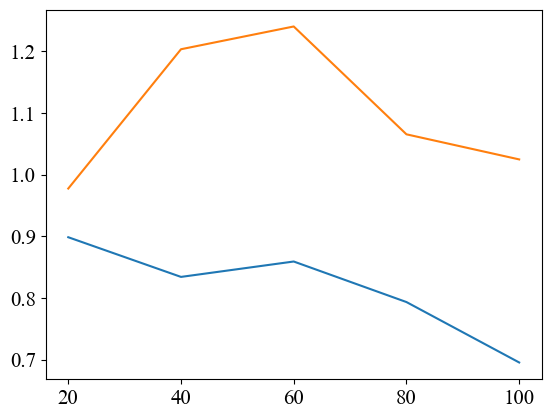

In [33]:
batch_size_range = np.array([20, 40, 60, 80, 100], int)
plt.figure()
mi_vals, mi_test_vals = [], [] 
for bs in batch_size_range:
    test = gaussian_filter1d(np.nan_to_num(mib_test[bs]), sigma=1)
    mi_vals.append(mib[bs][np.argmax(test)])
    mi_test_vals.append(mib_test[bs][np.argmax(test)])
plt.plot(batch_size_range, np.array(mi_test_vals))
plt.plot(batch_size_range, np.array(mi_vals))

In [26]:
from tqdm.auto import tqdm
# Empty arrays and do the run, will take forever
mi = {}
mi_test = {}
models = {}
ids = {}
batch_size_range = np.array([128, 256, 512, 1024])
neuron = np.random.choice(X.shape[0])

for bs in batch_size_range:
    for dz in tqdm(range(1, params['max_dz']+1)):
        print(f'Starting dz = {dz}')
        for j in range(params['n_trials']):
            this_params = {**params, 'embed_dim': dz, 'batch_size': bs}
            print(f'batch size = {bs}, dz = {dz}, trial = {j+1}')
            torch.cuda.empty_cache()
            dataset = BatchedDataset(X[[neuron],:], Y, this_params['batch_size'])
            full_dataset = create_cnn_data_split(dataset, 60, train_fraction=0.9, eval_fraction=0.9, device=device)
            mis, mis_test, _ = train_cnn_model(DSIB, full_dataset, this_params)
            # full_dataset = create_cnn_data_split(dataset, train_fraction=0.9, eval_fraction=0.9, device=device)
            # mis, mis_test = train_model(DSIB, full_dataset, this_params)
            # mis_test, train_id = train_model_no_eval(DSIB, full_dataset, this_params, model_cache_dir)
            # mod = retrieve_best_model(model_cache_dir, mis_test, train_id=train_id, burn_in=1)
            # Store results
            key = f"trial_{j}_dz_{dz}_bs_{bs}"
            mi[key] = mis
            mi_test[key] = mis_test
            # models[key] = mod
            # ids[key] = train_id
torch.cuda.empty_cache()


  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 128, dz = 1, trial = 1
Train time = 0.7406737804412842
Eval time = 0.016013622283935547
Test time = 0.005005598068237305
Epoch: 1, DSIB, train: -8.574826097174082e-06, test: -8.78915216162568e-06
Train time = 0.5104649066925049
Eval time = 0.002001047134399414
Test time = 0.002002716064453125
Epoch: 2, DSIB, train: -3.644090156740276e-06, test: -3.7664101455447963e-06
Train time = 0.5234763622283936
Eval time = 0.002001523971557617
Test time = 0.002003192901611328
Epoch: 3, DSIB, train: -1.7990419109992217e-06, test: -2.378149929427309e-06
Train time = 0.5004549026489258
Eval time = 0.002001523971557617
Test time = 0.002003192901611328
Epoch: 4, DSIB, train: -1.598914082023839e-06, test: -1.5391580063806032e-06
Train time = 0.5214755535125732
Eval time = 0.002002716064453125
Test time = 0.001001119613647461
Epoch: 5, DSIB, train: -8.14888323930063e-07, test: -1.0640453638188774e-06
Train time = 0.5054595470428467
Eval time = 0.002002716064453125
Test time =

  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 256, dz = 1, trial = 1
Train time = 0.43439412117004395
Eval time = 0.01401376724243164
Test time = 0.005004405975341797
Epoch: 1, DSIB, train: -0.00040275955689139664, test: -0.00039908778853714466
Train time = 0.45641469955444336
Eval time = 0.002002239227294922
Test time = 0.0009999275207519531
Epoch: 2, DSIB, train: -2.252435115224216e-05, test: -2.9693497708649375e-05
Train time = 0.4253857135772705
Eval time = 0.0020024776458740234
Test time = 0.002001047134399414
Epoch: 3, DSIB, train: -3.789873744608485e-06, test: -5.052479991718428e-06
Train time = 0.42738842964172363
Eval time = 0.0020017623901367188
Test time = 0.003002643585205078
Epoch: 4, DSIB, train: -1.6487376797158504e-06, test: -1.6182557374122553e-06
Train time = 0.4263877868652344
Eval time = 0.002187490463256836
Test time = 0.0010008811950683594
Epoch: 5, DSIB, train: -1.8684459064388648e-06, test: -1.3424544249573955e-06
Train time = 0.4133765697479248
Eval time = 0.002000570297241211


  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 512, dz = 1, trial = 1
Train time = 0.6295723915100098
Eval time = 0.016015052795410156
Test time = 0.007005929946899414
Epoch: 1, DSIB, train: -0.01148455310612917, test: -0.01034874189645052
Train time = 0.6191556453704834
Eval time = 0.0030028820037841797
Test time = 0.0020017623901367188
Epoch: 2, DSIB, train: -0.00048147584311664104, test: -0.00042977623525075614
Train time = 0.6265697479248047
Eval time = 0.0020020008087158203
Test time = 0.0010004043579101562
Epoch: 3, DSIB, train: -6.341320113278925e-05, test: -6.500879680970684e-05
Train time = 0.6385796070098877
Eval time = 0.0020020008087158203
Test time = 0.0020020008087158203
Epoch: 4, DSIB, train: -1.6865586076164618e-05, test: -1.9105924366158433e-05
Train time = 0.6155598163604736
Eval time = 0.002002239227294922
Test time = 0.0020017623901367188
Epoch: 5, DSIB, train: -1.0816255780810025e-05, test: -1.3565530025516637e-05
Train time = 0.6215651035308838
Eval time = 0.0020024776458740234
Tes

  0%|          | 0/12 [00:00<?, ?it/s]

Starting dz = 1
batch size = 1024, dz = 1, trial = 1
Train time = 0.5445020198822021
Eval time = 0.020017385482788086
Test time = 0.00600433349609375
Epoch: 1, DSIB, train: -0.012846967205405235, test: -0.01035755593329668
Train time = 0.5034575462341309
Eval time = 0.0020012855529785156
Test time = 0.002001523971557617
Epoch: 2, DSIB, train: -0.005014576483517885, test: -0.00434390502050519
Train time = 0.5044593811035156
Eval time = 0.0030014514923095703
Test time = 0.002002716064453125
Epoch: 3, DSIB, train: -0.0008515996159985662, test: -0.0006777612725272775
Train time = 0.5054595470428467
Eval time = 0.0020017623901367188
Test time = 0.002001523971557617
Epoch: 4, DSIB, train: -8.7614098447375e-05, test: -7.642570562893525e-05
Train time = 0.5024571418762207
Eval time = 0.0020017623901367188
Test time = 0.001001119613647461
Epoch: 5, DSIB, train: -5.419558874564245e-06, test: -4.655436441680649e-06
Train time = 0.5024561882019043
Eval time = 0.002001523971557617
Test time = 0.002

In [30]:
neuron

25

KeyError: 'trial_0_dz_1_bs_20'

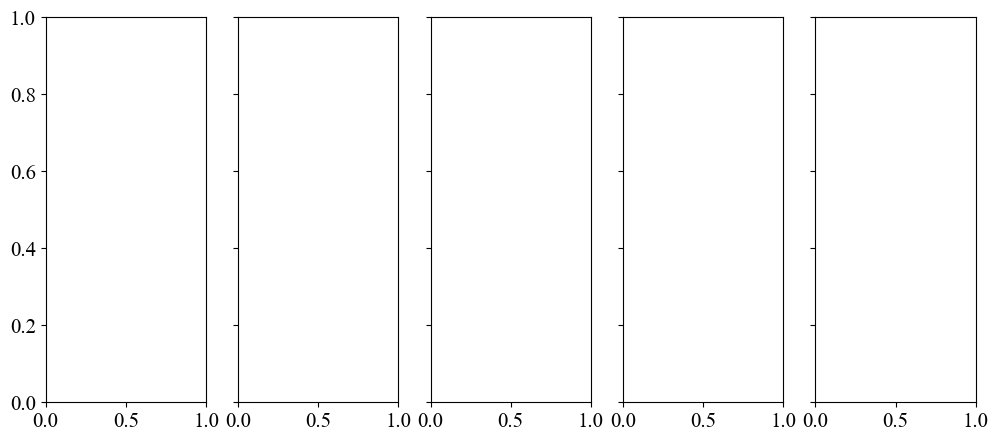

In [34]:
# Define sigma, a small number is usually the best choice
sigma=1 # (or 2 at most)

fig, ax = plt.subplots(1, len(batch_size_range), figsize=(12,5), sharey=True)
for i,bs in enumerate(batch_size_range):    
    dz_means, dz_stds = [], []
    dz_train_means, dz_train_stds = [], []
    for dz in range(1, params['max_dz']+1):
        mi_trials = []
        mi_train = []
        for j in range(params['n_trials']):
            key = f"trial_{j}_dz_{dz}_bs_{bs}"
            # Convert Nan to zeros and smooth
            # test = gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma) / bs * np.log2(np.e) * 1000
            train = gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma) * np.log2(np.e) #/ (0.0005 * bs)
            test = gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma) * np.log2(np.e) #/ (0.0005 * bs)
            # Pick the epoch with highest test value and get corresponding train
            best = np.argmax(test)
            mi_trials.append(test[best])
            mi_train.append(train[best])
        dz_means.append(np.mean(np.array(mi_trials)).flatten())
        dz_stds.append(np.std(np.array(mi_trials)).flatten())
        dz_train_means.append(np.mean(np.array(mi_train)).flatten())
        dz_train_stds.append(np.std(np.array(mi_train)).flatten())
    b = ax[i].errorbar(
        range(1, params['max_dz']+1), np.array(dz_means).flatten(), 
        yerr=np.array(dz_stds).flatten(), 
        fmt='s:', capsize=4)
    # ax[i].errorbar(
    #     range(1, params['max_dz']+1), np.array(dz_train_means).flatten(), 
    #     yerr=np.array(dz_train_stds).flatten(), 
    #     fmt='s:', capsize=4)

    # Set title and scales
    ax[i].set_title(str(bs))
    ax[i].set_xlabel(r'$dz$')
    if i == 0:
        ax[i].set_ylabel(r'$I(X;Y) \text{(bits/s)}$');
    # ax[i].set_ylim(-1, 4)


trial_0_dz_10_bs_64


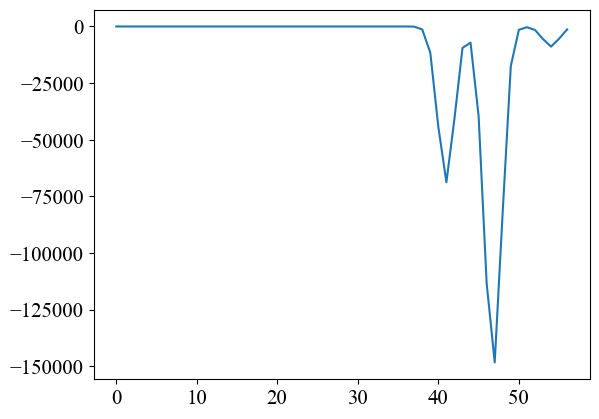

In [72]:
key = random.choice(list(mi_test.keys()))
sigma = 1
# plt.plot(gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma))
plt.plot(gaussian_filter1d(np.nan_to_num(mi_test[key]) * np.log2(np.e), sigma=sigma))
# plt.gca().set_ylim(0)
print(key)

In [82]:
import pickle

with open(os.path.join(main_dir, 'mi_test_2025-04-27.pkl'), 'wb') as f:
    pickle.dump(mi_test, f)
with open(os.path.join(main_dir, 'ids_2025-04-27.pkl'), 'wb') as f:
    pickle.dump(ids, f)


In [91]:
ids

{'trial_0_dz_5_bs_64': 'DSIB_dz-5_bs-64_8fd6f693-0e8c-4050-80f0-71743727faf4',
 'trial_1_dz_5_bs_64': 'DSIB_dz-5_bs-64_53c1ac4c-c23f-4fb7-b0de-03609854555d',
 'trial_2_dz_5_bs_64': 'DSIB_dz-5_bs-64_980c7b88-ae7e-45c8-8654-43988f324259',
 'trial_0_dz_6_bs_64': 'DSIB_dz-6_bs-64_f5780180-bfd3-435e-b811-ea7695d4a1b5',
 'trial_1_dz_6_bs_64': 'DSIB_dz-6_bs-64_bd177624-0f1d-47e3-9b66-3efe1affcb26',
 'trial_2_dz_6_bs_64': 'DSIB_dz-6_bs-64_e444d9e9-1f41-4509-8b87-95f2bcb4c6ba',
 'trial_0_dz_7_bs_64': 'DSIB_dz-7_bs-64_9dc5f773-c58a-41b1-8d58-f154bc18fe83',
 'trial_1_dz_7_bs_64': 'DSIB_dz-7_bs-64_136f4efa-0772-4a42-b8d1-163fcca65eda',
 'trial_2_dz_7_bs_64': 'DSIB_dz-7_bs-64_aa666a3e-dd74-47c8-9e75-a2260fe347af',
 'trial_0_dz_8_bs_64': 'DSIB_dz-8_bs-64_aaf1e6a7-8d80-4aba-bfe0-8fc840cb522f',
 'trial_1_dz_8_bs_64': 'DSIB_dz-8_bs-64_ef96a2d7-2bcc-45d7-b9ec-20ad29bfc0a7',
 'trial_2_dz_8_bs_64': 'DSIB_dz-8_bs-64_b53fd0ff-c038-4b42-b96d-2a9a32ea69e8',
 'trial_0_dz_9_bs_64': 'DSIB_dz-9_bs-64_6ce81eb9-0f7

In [ ]:
with open(os.path.join(main_dir, 'mi_test_2025-04-27.pkl'), 'rb') as f:
    bob = pickle.load(f)
with open(os.path.join(main_dir, 'ids_2025-04-27.pkl'), 'rb') as f:
    bob = pickle.load(f)

Okay, so running on the whole dataset takes a long time. 


Scheme for a given moth:
- X embedding dimension sizes
- Y repeats at each embedding dim size
- Z batch sizes